In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import tensorflow as tf
from keras.preprocessing.image import load_img
import os

In [2]:
src_dir = "/kaggle/input/rice-image-classification-dataset/Rice_Image_Dataset"

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [4]:
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    src_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=1
)
validation_generator = validation_datagen.flow_from_directory(
    src_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=1
)

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [6]:
base_model = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 7, 7, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           4,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 4,805 (18.77 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [9]:
all_epochs_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/mobilenet_epoch_{epoch:02d}.keras',
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False
)
best_weights_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/mobilenetv3_best.weights.h5',  # ✅ ends with .weights.h5
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    mode='min', 
    restore_best_weights=True, 
    verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    patience=3, 
    factor=0.5, 
    min_lr=1e-6, 
    verbose=1
)

In [10]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[all_epochs_checkpoint, best_weights_checkpoint, reduce_lr, early_stopping]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 505ms/step - accuracy: 0.6781 - loss: 0.8536
Epoch 1: val_loss improved from inf to 0.19674, saving model to /kaggle/working/mobilenetv3_best.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1071s 562ms/step - accuracy: 0.6783 - loss: 0.8532 - val_accuracy: 0.9470 - val_loss: 0.1967 - learning_rate: 1.0000e-04
Epoch 2/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9537 - loss: 0.1667
Epoch 2: val_loss improved from 0.19674 to 0.13103, saving model to /kaggle/working/mobilenetv3_best.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 732s 389ms/step - accuracy: 0.9538 - loss: 0.1667 - val_accuracy: 0.9646 - val_loss: 0.1310 - learning_rate: 1.0000e-04
Epoch 3/10
1874/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.9697 - loss: 0.1080
Epoch 3: val_loss improved from 0.13103 to 0.10126, saving model to /kaggle/working/mobilenetv3_best.weights.h5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 724s 385ms/step - accuracy: 0.9697 - loss: 0.1080 - val_accuracy: 0.9727 - 

In [11]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 52ms/step - accuracy: 0.9900 - loss: 0.0399
Validation Accuracy: 98.87%
Validation Loss: 0.0440


In [12]:
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

469/469 ━━━━━━━━━━━━━━━━━━━━ 33s 62ms/step


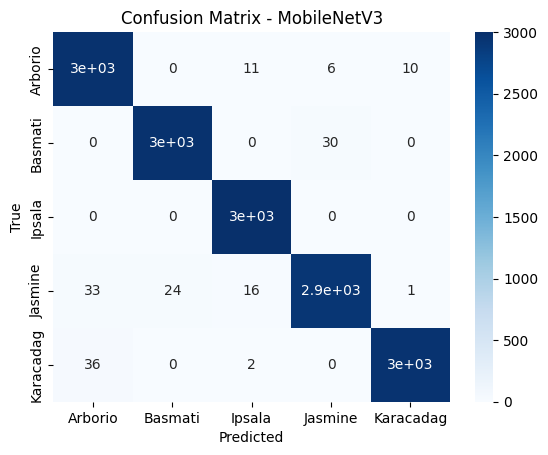

In [13]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - MobileNetV3')
plt.show()

Enter number of predictions to display:  5


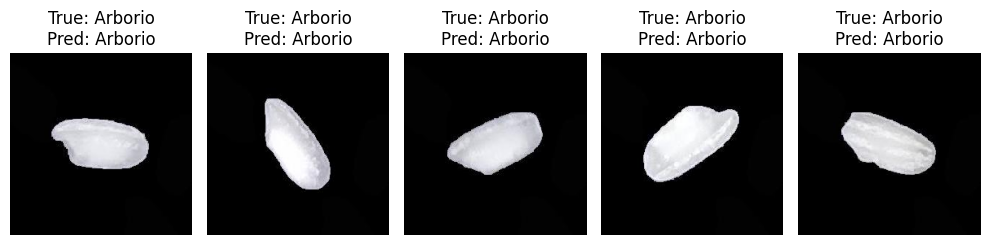

In [15]:
num_to_display = int(input("Enter number of predictions to display: "))
plt.figure(figsize=(10, 10))
for i in range(num_to_display):
    img_path = validation_generator.filepaths[i]
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot((num_to_display // 5) + 1, 5, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"True: {class_labels[true_classes[i]]}\nPred: {class_labels[predicted_classes[i]]}")
plt.tight_layout()
plt.show()

In [16]:
model.save('/kaggle/working/mobilenetv3_best_model.keras')
print("Best full model saved successfully!")

Best full model saved successfully!


In [17]:
from tensorflow.keras.models import load_model

model = load_model('/kaggle/working/mobilenetv3_best_model.keras')
print("Best full model loaded successfully!")

Best full model loaded successfully!
